# I. Set Up

In [1]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import umap
import seaborn as sns
import fnmatch
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

2023-04-30 04:15:18.132747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dropdown(description='Set :', options=('Full', 'All', 'New', 'Bona', 'Full_oldie'), value='Full')

# II. Load Data

In [2]:
# Set ID
set_id = set_widget.value
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist2D*nE16*none*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='Histogram File :',disabled=False); input_widget



Dropdown(description='Histogram File :', options=('hist2D-Full-nE16-nt24-normnone.pkl',), value='hist2D-Full-n…

In [3]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

Number of Features:  95473
Number of Property Sets:  95473


# III. CLUSTERING

In [4]:
files = os.listdir(f'{global_path}/{set_id}/')
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*nE16*perp30*lr80*it4500*PCA15*rs11.csv')]
tsne_widget = widgets.Dropdown(options=tsne_files[:],value=tsne_files[0],description='TSNE File :',disabled=False); tsne_widget

Dropdown(description='TSNE File :', options=('tsne-Full-hist2D-Full-nE16-nt24-normnone-2D-perp30-lr80-ee1-it45…

In [5]:
import hdbscan 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Load 
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')
# Filter on variability
df_properties_filter = df_properties#.loc[df_properties["var_prob_m"] >= 0.8]
filter_ids = df_properties_filter["obsreg_id"]
df_tsne_filter = df_tsne[df_tsne["obsreg_id"].isin(filter_ids)]
tsne12 = df_tsne_filter[['tsne1', 'tsne2']].values

In [6]:
# Run DBSCAN
eps = 2.1
ms = 22
dbscan=DBSCAN(eps=eps,min_samples = ms)
clusters=dbscan.fit(tsne12)
labels=clusters.labels_
n_clusters = len(set(labels))- (1 if -1 in labels else 0)
df_tsne_filter['cluster'] = labels

# Save TSNE Output
df_tsne_filter.to_csv(f'{global_path}/{set_id}/DBSCANres-{set_id}-{tsne_file}-EPS{eps}-MS{ms}.csv', index=False)

#Display Performance
silhouette_avg = silhouette_score(tsne12, labels)
ch_score = calinski_harabasz_score(tsne12, labels)
db_score = davies_bouldin_score(tsne12, labels)
print("Calinski-Harabasz Index: ", ch_score)
print("Davies-Bouldin Index: ", db_score)
print("Silhouette score:", silhouette_avg)
print("Number of Clusters:", n_clusters)


Calinski-Harabasz Index:  774.4490266077161
Davies-Bouldin Index:  1.6833185232104604
Silhouette score: -0.5096374656249467
Number of Clusters: 42


SHOW

In [7]:
# Load DBSCAN RESULT
files = os.listdir(f'{global_path}/{set_id}/')
dbscan_files = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*MS22*csv')]
dbscan_widget = widgets.Dropdown(options=dbscan_files[:],value=dbscan_files[0],description='TSNE File :',disabled=False); dbscan_widget

Dropdown(description='TSNE File :', options=('DBSCANres-Full-tsne-Full-hist2D-Full-nE16-nt24-normnone-2D-perp3…

In [8]:
# Load the DataFrame from the CSV file
dbscan_file = dbscan_widget.value
df_tsne_filter = pd.read_csv(f'{global_path}/{set_id}/{dbscan_file}')

#####SELECTED ANOMALIES
flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
dips_maybe = ['13814_586','13813_218','13828_596']

# DIPS ET AL
parmar = ['10783_10','10871_10','11059_10','9070_10','9072_10'] # LMXB dips!
distefano = ['13814_567']
m101ulx = ['4736_81','6170_74','4733_229','4737_74','5300_95','5322_229','6152_81']

ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']

# FLARES ET AL 
lin = ['4062_31', '13454_56','20635_58'] 
xue = ['957_208', '3389_274','15211_38','15214_29']
irwin = ['3926_13','7800_4','7799_16','8490_30']
glennie = ['12884_10']
jonker = ['803_90']
vasquez = ['2025_39','9546_17','9548_14','12264_54','15113_59']
vasquez = ['2025_39','9548_14','15113_59']
nandra = ['9875_166', '9456_274', '5849_62']
goulding =['8636_2', '8636_3'] # last one not listed 2012 2015

flares = ['4395_992','16444_1025','13637_1078','14368_489','14368_503','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','1042_24']

tsne_lin = df_tsne.loc[df_tsne['obsreg_id'].isin(lin)]
tsne_irwin = df_tsne.loc[df_tsne['obsreg_id'].isin(irwin)]
tsne_glennie = df_tsne.loc[df_tsne['obsreg_id'].isin(glennie)]
tsne_jonker = df_tsne.loc[df_tsne['obsreg_id'].isin(jonker)]
tsne_vasquez= df_tsne.loc[df_tsne['obsreg_id'].isin(vasquez)]
tsne_xue = df_tsne.loc[df_tsne['obsreg_id'].isin(xue)]
tsne_goulding = df_tsne.loc[df_tsne['obsreg_id'].isin(goulding)]
tsne_nandra = df_tsne.loc[df_tsne['obsreg_id'].isin(nandra)]
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares + flares_maybe)]

tsne_m101ulx = df_tsne.loc[df_tsne['obsreg_id'].isin(m101ulx)]
tsne_distefano = df_tsne.loc[df_tsne['obsreg_id'].isin(distefano)]
tsne_moredips = df_tsne.loc[df_tsne['obsreg_id'].isin(ieva + dips_maybe)]
tsne_parmar = df_tsne.loc[df_tsne['obsreg_id'].isin(parmar)] # LMXB

tsne_lin = df_tsne.loc[df_tsne['obsreg_id'].isin(lin)]
tsne_irwin = df_tsne.loc[df_tsne['obsreg_id'].isin(irwin)]
tsne_glennie = df_tsne.loc[df_tsne['obsreg_id'].isin(glennie)]
tsne_jonker = df_tsne.loc[df_tsne['obsreg_id'].isin(jonker)]
tsne_vasquez = df_tsne.loc[df_tsne['obsreg_id'].isin(vasquez)]
tsne_xue = df_tsne.loc[df_tsne['obsreg_id'].isin(xue)]
tsne_goulding = df_tsne.loc[df_tsne['obsreg_id'].isin(goulding)]
tsne_nandra = df_tsne.loc[df_tsne['obsreg_id'].isin(nandra)]
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares)]

tsne_m101ulx = df_tsne.loc[df_tsne['obsreg_id'].isin(m101ulx)]
tsne_distefano = df_tsne.loc[df_tsne['obsreg_id'].isin(distefano)]
tsne_moredips = df_tsne.loc[df_tsne['obsreg_id'].isin(ieva)]
tsne_parmar = df_tsne.loc[df_tsne['obsreg_id'].isin(parmar)] # LMXB

anomalies = pd.concat([tsne_lin,tsne_irwin,tsne_glennie,tsne_jonker,tsne_vasquez,tsne_xue,tsne_goulding,tsne_nandra,tsne_flares,tsne_m101ulx, tsne_distefano, tsne_moredips,tsne_parmar])
anomalies.head(50)

,tsne1,tsne2,obsreg_id
14036,41.823260,-67.222460,13454-56
45867,92.257545,33.311947,20635-58
63365,108.249750,-9.345040,4062-31
10836,-53.295420,-67.402720,12884-10
86183,-60.165783,96.497180,803-90
23967,-46.230717,95.586500,15113-59
44094,40.207740,-73.757515,2025-39
92701,-16.094135,111.121970,9548-14
24584,25.158821,-84.549240,15211-38
59286,-51.541973,100.759910,3389-274


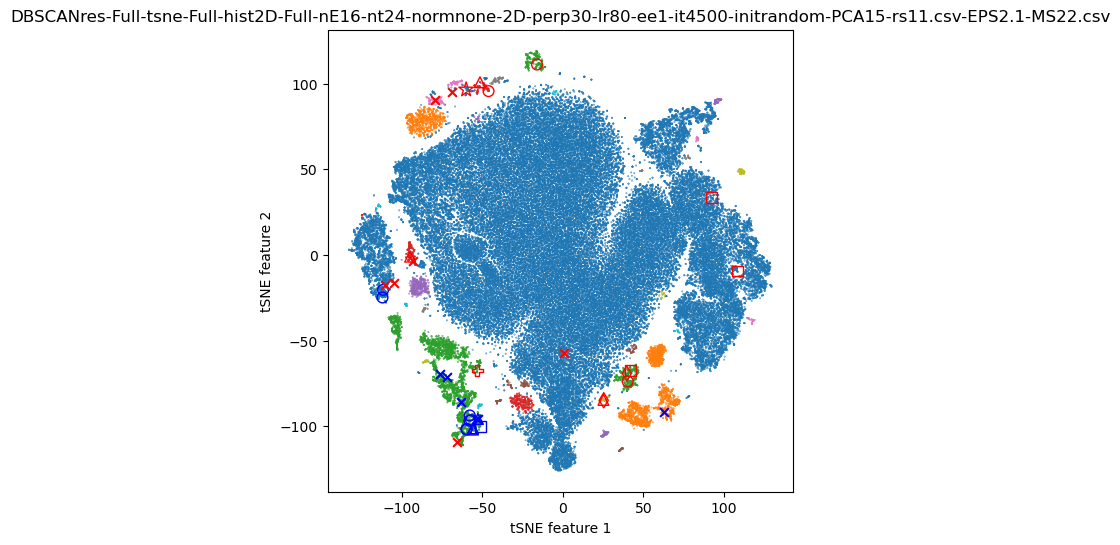

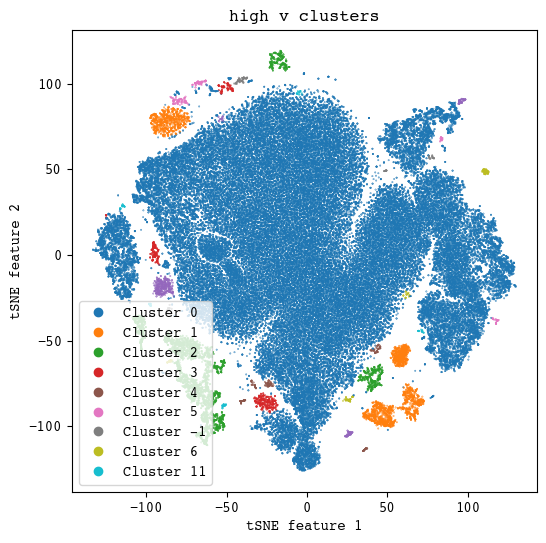

In [9]:
# PLOT
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
cluster = axs.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], cmap = 'tab10', s=0.1)
axs.set_xlabel('tSNE feature 1')
axs.set_ylabel('tSNE feature 2')
axs.set_title(f'high v clusters')
unique_clusters = df_tsne_filter['cluster'].unique()
legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]

fig, axs2 = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
cluster = axs2.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], cmap = 'tab10', s=0.1)
axs2.set_xlabel('tSNE feature 1')
axs2.set_ylabel('tSNE feature 2')
axs2.set_title(f'high v clusters')
unique_clusters = df_tsne_filter['cluster'].unique()
legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]

markersize = 40
c_f = 'red'
c_d = 'blue'

axs.scatter(tsne_distefano['tsne1'], tsne_distefano['tsne2'], edgecolors=c_d, marker='s', s=markersize*1.5, facecolor='none', label='di Stefano et al. (2021)')
axs.scatter(tsne_m101ulx['tsne1'], tsne_m101ulx['tsne2'], edgecolors=c_d, marker='o', s=markersize*1.5, facecolor='none', label='2E 1402.4+5440 (ULX)')
axs.scatter(tsne_parmar['tsne1'], tsne_parmar['tsne2'], edgecolors=c_d, marker='^', s=markersize*1.5, facecolor='none', label='V* UY Vol (LMXB)')
axs.scatter(tsne_moredips['tsne1'], tsne_moredips['tsne2'], c=c_d, marker='x', s=markersize*1, facecolor='none', label='Other Dips')
 
axs.scatter(tsne_lin['tsne1'], tsne_lin['tsne2'], edgecolors=c_f, marker='s', s=markersize*1.5, facecolor='none', label='Lin et al. (2022)')
axs.scatter(tsne_vasquez['tsne1'], tsne_vasquez['tsne2'], edgecolors=c_f, marker='o', s=markersize*1.5, facecolors='none', label='Vásquezet al. (2022)')
axs.scatter(tsne_xue['tsne1'], tsne_xue['tsne2'], edgecolors=c_f, marker='^', s=markersize*1.5, facecolor='none', label='Xue et al. (2019)')
axs.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c=c_f, marker='x', s=markersize*1, facecolor='none', label='Other Flares')
axs.scatter(tsne_nandra['tsne1'], tsne_nandra['tsne2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Nandra et al. (2015)')
axs.scatter(tsne_glennie['tsne1'], tsne_glennie['tsne2'], edgecolors=c_f, marker='P', s=markersize*1.5, facecolor='none', label='Glennie et al. (2015)')
axs.scatter(tsne_jonker['tsne1'], tsne_jonker['tsne2'], edgecolors=c_f, marker='*', s=markersize*3, facecolor='none', label='Jonker et al. (2013)')


axs2.legend(cluster.legend_elements()[0], legend_labels)
axs.set_title(dbscan_file)


plt.show()


In [ ]:
# # Run HDBSCAN
# min_cluster_size = 50
# min_samples = 5
# clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
# cluster_labels = clusterer.fit_predict(tsne12)
# n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
# n_noise = list(cluster_labels).count(-1)
# df_tsne_filter['cluster'] = cluster_labels
# silhouette_avg = silhouette_score(tsne12, cluster_labels)
# print(f"Silhouette Score: {silhouette_avg}")
# print(f"Number of clusters: {n_clusters}")
# print(f"Number of noise points: {n_noise}")

# Run KMeans
k_values = range(2, 30)

# # Try each value of K and calculate the silhouette score
# best_score = -1
# best_k = None
# for k in k_values:
#     kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, random_state=42)
#     kmeans.fit(tsne12)
#     score = silhouette_score(tsne12, kmeans.labels_)
#     if score > best_score:
#         best_score = score
#         best_k = k

# Use the best value of K to cluster the data
# best_k = 500
# kmeans = KMeans(n_clusters=best_k, init='k-means++', max_iter=100, random_state=42)
# cluster_labels = kmeans.fit_predict(tsne12)
# df_tsne_filter['cluster'] = cluster_labels
# n_clusters = len(set(cluster_labels))
# n_noise = list(cluster_labels).count(-1)
# print(f"Number of clusters: {n_clusters}")
# print(f"Number of noise points: {n_noise}")



# from sklearn.cluster import DBSCAN
# from sklearn.metrics import pairwise_distances
# from sklearn.metrics import silhouette_score
# import numpy as np
# import matplotlib.pyplot as plt

# # Compute the distance matrix for your dataset
# D = pairwise_distances(X, metric='euclidean')

# # Range of eps and min_samples values to try
# eps_range = np.arange(0.1, 1.0, 0.1)
# min_samples_range = range(5, 15)

# # Compute the silhouette score for each combination of eps and min_samples
# silhouette_scores = np.zeros((len(eps_range), len(min_samples_range)))
# for i, eps in enumerate(eps_range):
#     for j, min_samples in enumerate(min_samples_range):
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(X)
#         if len(set(labels)) > 1:
#             silhouette_scores[i,j] = silhouette_score(X, labels)

# # Plot the silhouette scores as a heatmap
# plt.imshow(silhouette_scores, cmap='hot', interpolation='nearest', origin='lower')
# plt.xlabel('min_samples')
# plt.xticks(range(len(min_samples_range)), min_samples_range)
# plt.ylabel('eps')
# plt.yticks(range(len(eps_range)), eps_range)
# plt.colorbar()
# plt.show()

# # Find the combination of eps and min_samples with the highest silhouette score
# i, j = np.unravel_index(np.argmax(silhouette_scores), silhouette_scores.shape)
# eps = eps_range[i]
# min_samples = min_samples_range[j]
# print("Optimal eps:", eps)
# print("Optimal min_samples:", min_samples)